In [1]:
# !pip install river

  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 9.4 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------- ----------------------------- 10.7/41.2 MB 61.0 MB/s eta 0:00:01
   -------------------- ------------------- 20.7/41.2 MB 52.3 MB/s eta 0:00:01
   --------------------------------- ------ 34.9/41.2 MB 58.3 MB/s eta 0:00:01
   ---------------------------------------- 41.2/41.2 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [25]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from sklearn.preprocessing import StandardScaler
from collections import deque
from sklearn.metrics import f1_score
from river import drift

In [38]:
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)

with open('models/XGB_model.pkl','rb') as model_file:
    xgb_model = joblib.load(model_file)

print("Scaler and KNN model loaded successfully!")

Scaler and KNN model loaded successfully!


In [39]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [40]:
static_model = xgb_model
dynamic_model = copy.deepcopy(xgb_model)

In [41]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

adwin_dynamic = drift.ADWIN()
adwin_static = drift.ADWIN()

<h2>Streaming using ADWIN </h2>

In [42]:
for idx, message in enumerate(consumer):
    # Decode and preprocess the message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    # Clean up columns
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # Process label
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(
            lambda x: x.strip().replace('\\n"', '').replace('"', '')
        )
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    # Process features
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    # Scale features
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])
    y_new = int(row_df['label'].values[0])

    # Get predictions
    dynamic_pred = dynamic_model.predict(X_new_dynamic)[0]
    static_pred = static_model.predict(X_new_static)[0]
    
    # Track prediction correctness (1 if correct, 0 if wrong)
    dynamic_error = 1 if (dynamic_pred == y_new) else 0
    static_error = 1 if (static_pred == y_new) else 0

    # Update PageHinkley detectors
    adwin_dynamic.update(dynamic_error)
    adwin_static.update(static_error)

    window_data.append((X_new_dynamic[0], y_new, dynamic_pred, static_pred))

    # Log progress
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")

    # Process window when full
    if len(window_data) == window_size:
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]

        # Compute metrics (for logging)
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        print(f"\nWindow {window_count + 1} complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Check for drift in dynamic model
        if adwin_dynamic.drift_detected:
            print(f"Drift detected in dynamic model! Retraining...")
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            # Update scaler with EMA
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Retrain dynamic model
            dynamic_model.fit(X_window, y_window)
            ph_dynamic.reset()  # Reset detector after retraining

        # Optional: Monitor static model (no retraining)
        if adwin_static.drift_detected:
            print(f"Warning: Drift detected in static model (not retraining)")

        # Reset window
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming.")

Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length', 'bwd header length', 'fwd packets/s', 'bwd packets/s', 'min packet length', 'max packet length', 'packet length mean', 'packet length std', 'packet length variance', 'fin flag count', 'syn flag count', 'rst flag count', 'psh flag count', 'ack flag count', 'urg flag count',

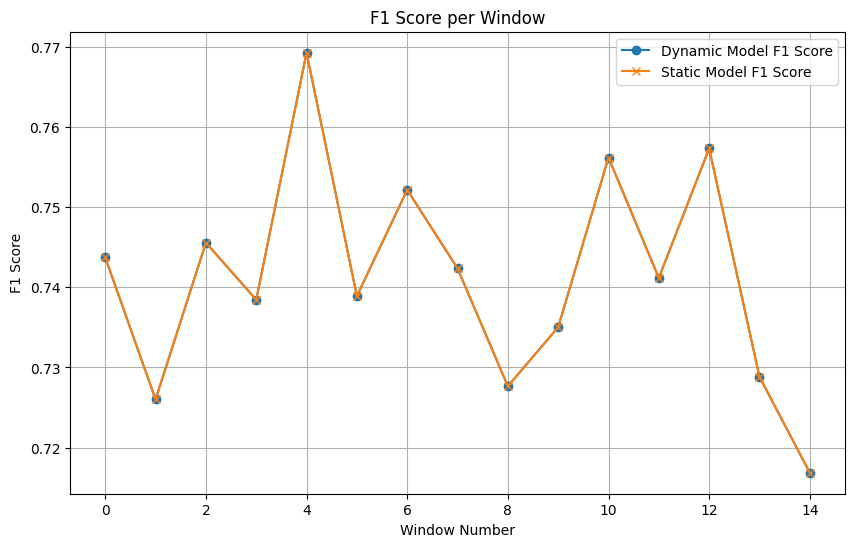

In [43]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()


<h2> Streaming using PageHinkley </h2>

In [20]:
static_model = xgb_model
dynamic_model = copy.deepcopy(xgb_model)

In [21]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

ph_dynamic = drift.PageHinkley()
ph_static = drift.PageHinkley()

In [22]:
for idx, message in enumerate(consumer):
    # Decode and preprocess the message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    # Clean up columns
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # Process label
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(
            lambda x: x.strip().replace('\\n"', '').replace('"', '')
        )
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    # Process features
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    # Scale features
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])
    y_new = int(row_df['label'].values[0])

    # Get predictions
    dynamic_pred = dynamic_model.predict(X_new_dynamic)[0]
    static_pred = static_model.predict(X_new_static)[0]
    
    # Track prediction correctness (1 if correct, 0 if wrong)
    dynamic_error = 1 if (dynamic_pred == y_new) else 0
    static_error = 1 if (static_pred == y_new) else 0

    # Update PageHinkley detectors
    ph_dynamic.update(dynamic_error)
    ph_static.update(static_error)

    window_data.append((X_new_dynamic[0], y_new, dynamic_pred, static_pred))

    # Log progress
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")

    # Process window when full
    if len(window_data) == window_size:
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]

        # Compute metrics (for logging)
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        print(f"\nWindow {window_count + 1} complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Check for drift in dynamic model
        if ph_dynamic.drift_detected:
            print(f"Drift detected in dynamic model! Retraining...")
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            # Update scaler with EMA
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Retrain dynamic model
            dynamic_model.fit(X_window, y_window)
            ph_dynamic.reset()  # Reset detector after retraining

        # Optional: Monitor static model (no retraining)
        if ph_static.drift_detected:
            print(f"Warning: Drift detected in static model (not retraining)")

        # Reset window
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming.")

Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window 1 complete:
  Dynamic Model -> F1: 0.765
  Static Model  -> F1: 0.765
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window 2 complete:
  Dynamic Model -> F1: 0.722
  Static Model  -> F1: 0.722
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max

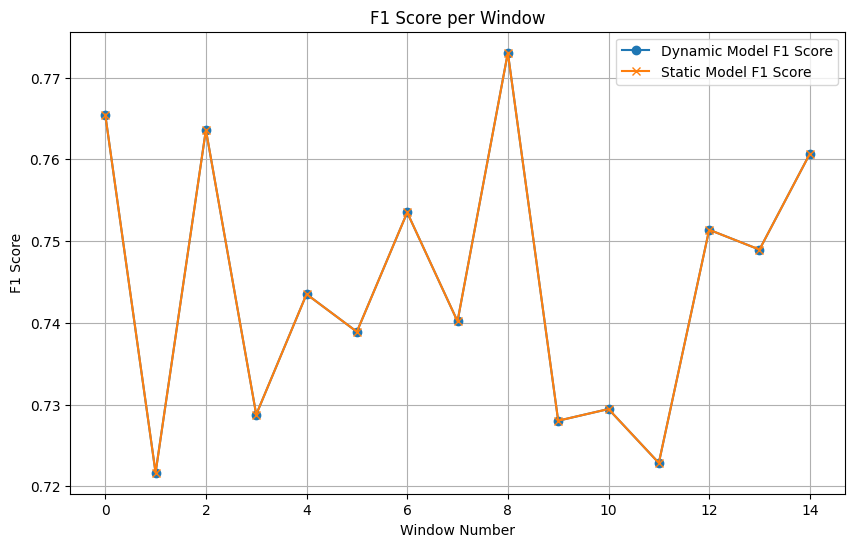

In [23]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()


<h2> Streaming using KSWIN </h2>

In [26]:
static_model = xgb_model
dynamic_model = copy.deepcopy(xgb_model)

In [27]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

kswin_dynamic = drift.KSWIN(seed=2021)
kswin_static = drift.KSWIN(seed=2021)

In [28]:
for idx, message in enumerate(consumer):
    # Decode and preprocess the message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    # Clean up columns
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # Process label
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(
            lambda x: x.strip().replace('\\n"', '').replace('"', '')
        )
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    # Process features
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    # Scale features
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])
    y_new = int(row_df['label'].values[0])

    # Get predictions
    dynamic_pred = dynamic_model.predict(X_new_dynamic)[0]
    static_pred = static_model.predict(X_new_static)[0]
    
    # Track prediction correctness (1 if correct, 0 if wrong)
    dynamic_error = 1 if (dynamic_pred == y_new) else 0
    static_error = 1 if (static_pred == y_new) else 0

    # Update KSWIN detectors
    kswin_dynamic.update(dynamic_error)
    kswin_static.update(static_error)

    window_data.append((X_new_dynamic[0], y_new, dynamic_pred, static_pred))

    # Log progress
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")

    # Process window when full
    if len(window_data) == window_size:
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]

        # Compute metrics (for logging)
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        print(f"\nWindow {window_count + 1} complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Check for drift in dynamic model
        if kswin_dynamic.drift_detected:
            print(f"Drift detected in dynamic model! Retraining...")
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            # Update scaler with EMA
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Retrain dynamic model
            dynamic_model.fit(X_window, y_window)
            kswin_dynamic.reset()  # Reset detector after retraining

        # Optional: Monitor static model (no retraining)
        if kswin_static.drift_detected:
            print(f"Warning: Drift detected in static model (not retraining)")

        # Reset window
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming.")

Consumed 0 messages
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages

Window 1 complete:
  Dynamic Model -> F1: 0.750
  Static Model  -> F1: 0.750
Consumed 1000 messages
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages

Window 2 complete:
  Dynamic Model -> F1: 0.755
  Static Model  -> F1: 0.755
Consumed 2000 messages
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max

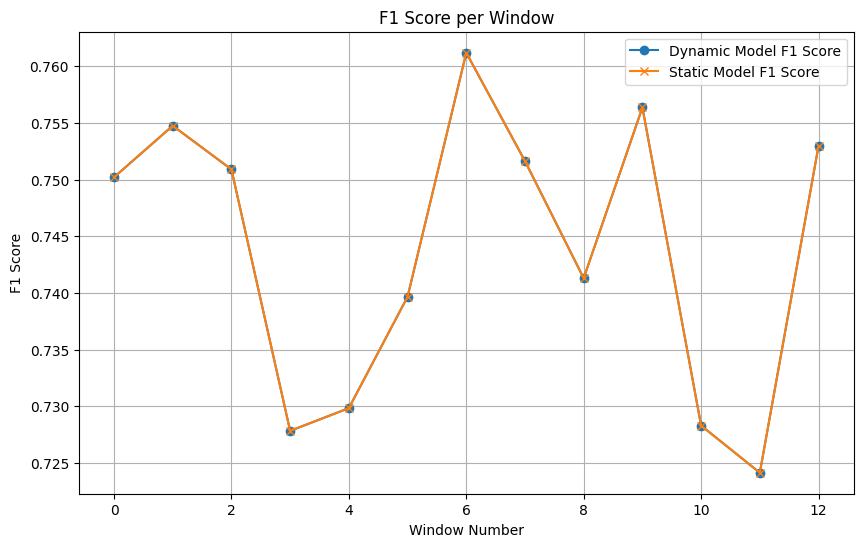

In [29]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()
